# Intensity Parameter Explorer — Low-Level Line Calculations

This notebook demonstrates the `Intensity` class, which calculates line-by-line intensities and optical depths directly from a `MoleculeLineList`. This is a **low-level interface** — no `Molecule` or `Spectrum` objects are used. Instead, you control temperature, column density, and line broadening directly.

Use this notebook to:
- Understand how individual molecular transitions respond to physical conditions
- Explore the transition from optically thin to optically thick regimes
- Visualize line intensity distributions and Boltzmann population effects

This is useful for debugging spectral models or understanding the underlying radiative transfer calculations.

In [1]:
# First, add the iSLAT package to the Python path
import sys
from pathlib import Path

# Navigate from notebook location to the iSLATTests directory (where iSLAT package lives)
notebook_dir = Path.cwd()
islat_root = notebook_dir.parent.parent.parent  # Interactive Widgets -> Notebooks -> Examples -> iSLATTests
if str(islat_root) not in sys.path:
    sys.path.insert(0, str(islat_root))

# Core libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Use the interactive widget backend for matplotlib
%matplotlib widget

# IPython widget libraries
import ipywidgets as widgets
from IPython.display import display, clear_output

# iSLAT low-level data types
from iSLAT.Modules.DataTypes import Intensity, Spectrum
from iSLAT.Modules.DataTypes.MoleculeLineList import MoleculeLineList

print("Imports successful!")
print(f"matplotlib backend: {matplotlib.get_backend()}")

Imports successful!
matplotlib backend: widget


In [2]:
# Define paths to HITRAN parameter files
data_dir = Path(islat_root) / "iSLAT" / "DATAFILES" / "HITRANdata"

# ============================================
# CONFIGURATION: Wavelength range for analysis
# ============================================
WAVELENGTH_RANGE = (14.0, 16.0)  # (min, max) in microns

# Available molecule files
molecule_files = {
    "H2O": str(data_dir / "data_Hitran_H2O.par"),
    "CO": str(data_dir / "data_Hitran_CO.par"),
    "CO2": str(data_dir / "data_Hitran_CO2.par"),
    "HCN": str(data_dir / "data_Hitran_2020_HCN.par"),
    "C2H2": str(data_dir / "data_Hitran_2020_C2H2.par"),
}

# Load H2O line list as default
line_list = MoleculeLineList(
    molecule_id="H2O",
    filename=molecule_files["H2O"]
)

print(f"Wavelength range: {line_list.get_wavelengths().min():.2f} - {line_list.get_wavelengths().max():.2f} μm")

print(f"Number of lines: {len(line_list.get_wavelengths())}")
print(f"Loaded molecule: {line_list.name}")

Wavelength range: 0.30 - 933.28 μm
Number of lines: 305561
Loaded molecule: H2O


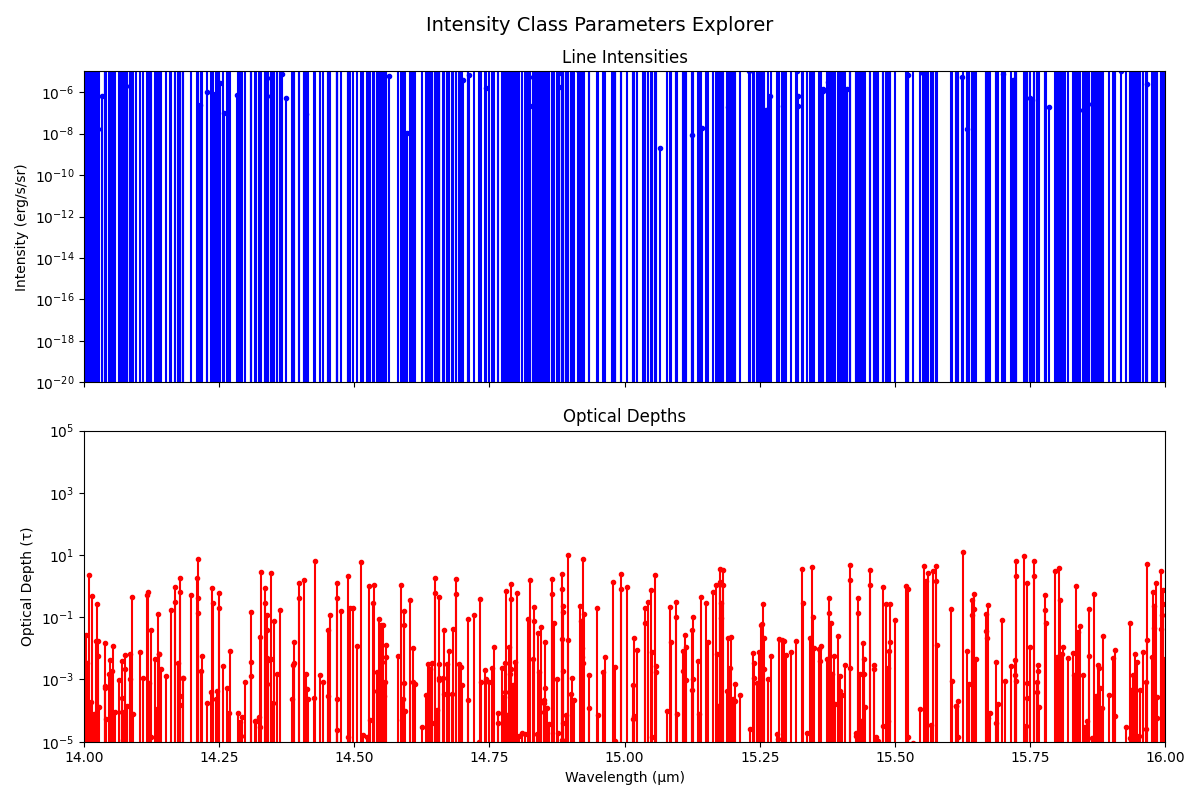

In [3]:
# --- Interactive Intensity Parameter Explorer ---

# Create the Intensity calculator
intensity_calc = Intensity(line_list)

# Initial calculation
intensity_calc.calc_intensity(t_kin=850, n_mol=1e18, dv=1.0)

# Create figure with two subplots: intensity vs wavelength, tau vs wavelength
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
fig.suptitle('Intensity Class Parameters Explorer', fontsize=14)

# Get wavelengths
wavelengths = line_list.get_wavelengths()

# Initial plots (stem plots for discrete lines)
markerline1, stemlines1, baseline1 = ax1.stem(wavelengths, intensity_calc.intensity, 
                                               linefmt='b-', markerfmt='b.', basefmt=' ')
ax1.set_ylabel('Intensity (erg/s/sr)')
ax1.set_title('Line Intensities')
ax1.set_yscale('log')
ax1.set_ylim(1e-20, 1e-5)

markerline2, stemlines2, baseline2 = ax2.stem(wavelengths, intensity_calc.tau, 
                                               linefmt='r-', markerfmt='r.', basefmt=' ')
ax2.set_xlabel('Wavelength (μm)')
ax2.set_ylabel('Optical Depth (τ)')
ax2.set_title('Optical Depths')
ax2.set_yscale('log')
ax2.set_ylim(1e-5, 1e5)

# Set initial x-limits using the configured wavelength range
ax1.set_xlim(WAVELENGTH_RANGE[0], WAVELENGTH_RANGE[1])

plt.tight_layout()

# --- Build parameter sliders ---
temp_slider = widgets.IntSlider(
    value=850, min=100, max=3000, step=50,
    description='Temperature (K):',
    continuous_update=False,
    style={'description_width': '140px'},
    layout=widgets.Layout(width='500px'),
)

# Column density uses a log scale
log_n_slider = widgets.FloatSlider(
    value=18.0, min=14.0, max=22.0, step=0.25,
    description='log_10 N (cm^-2):',
    continuous_update=False,
    style={'description_width': '140px'},
    layout=widgets.Layout(width='500px'),
    readout_format='.2f',
)

dv_slider = widgets.FloatSlider(
    value=1.0, min=0.1, max=10.0, step=0.1,
    description='Line broadening (km/s):',
    continuous_update=False,
    style={'description_width': '140px'},
    layout=widgets.Layout(width='500px'),
)

# Wavelength range slider
wave_range_slider = widgets.FloatRangeSlider(
    value=[WAVELENGTH_RANGE[0], WAVELENGTH_RANGE[1]],
    min=float(wavelengths.min()),
    max=float(wavelengths.max()),
    step=0.5,
    description='λ range (μm):',
    continuous_update=False,
    style={'description_width': '140px'},
    layout=widgets.Layout(width='500px'),
)

# Info label
info_label = widgets.HTML(
    value=f"<b>T={850} K, N=10^{18:.1f} cm^-2, dv={1.0:.1f} km/s</b>"
)

def update_intensity_plot(change):
    """Recalculate intensities and update the plots."""
    # Get current slider values
    temp = float(temp_slider.value)
    n_mol = 10 ** log_n_slider.value
    dv = float(dv_slider.value)
    
    # Recalculate intensities
    intensity_calc.calc_intensity(t_kin=temp, n_mol=n_mol, dv=dv)
    
    # Update info label
    info_label.value = (
        f"<b>T={temp:.0f} K, N=10^{log_n_slider.value:.1f} cm^-2, dv={dv:.1f} km/s</b><br>"
        f"Max τ = {intensity_calc.tau.max():.2e} | "
        f"Max I = {intensity_calc.intensity.max():.2e} erg/s/sr"
    )
    
    # Clear and redraw (stem plots don't update easily)
    ax1.clear()
    ax2.clear()
    
    ax1.stem(wavelengths, intensity_calc.intensity, linefmt='b-', markerfmt='b.', basefmt=' ')
    ax1.set_ylabel('Intensity (erg/s/sr)')
    ax1.set_title('Line Intensities')
    ax1.set_yscale('log')
    ax1.set_ylim(1e-20, 1e-5)
    
    ax2.stem(wavelengths, intensity_calc.tau, linefmt='r-', markerfmt='r.', basefmt=' ')
    ax2.set_xlabel('Wavelength (μm)')
    ax2.set_ylabel('Optical Depth (τ)')
    ax2.set_title('Optical Depths')
    ax2.set_yscale('log')
    ax2.set_ylim(1e-5, 1e5)
    
    # Update wavelength range
    xmin, xmax = wave_range_slider.value
    ax1.set_xlim(xmin, xmax)
    ax2.set_xlim(xmin, xmax)
    
    fig.canvas.draw_idle()

def update_xlim(change):
    """Update just the x-axis limits."""
    xmin, xmax = wave_range_slider.value
    ax1.set_xlim(xmin, xmax)
    ax2.set_xlim(xmin, xmax)
    fig.canvas.draw_idle()

# Connect sliders to update function
temp_slider.observe(update_intensity_plot, names='value')
log_n_slider.observe(update_intensity_plot, names='value')
dv_slider.observe(update_intensity_plot, names='value')
wave_range_slider.observe(update_xlim, names='value')

# Display controls
controls = widgets.VBox([
    info_label,
    temp_slider,
    log_n_slider,
    dv_slider,
    wave_range_slider,
])
display(controls)
plt.show()

## Intensity Statistics Explorer

This section shows statistics about the calculated intensities and allows exploring the distribution of line strengths.

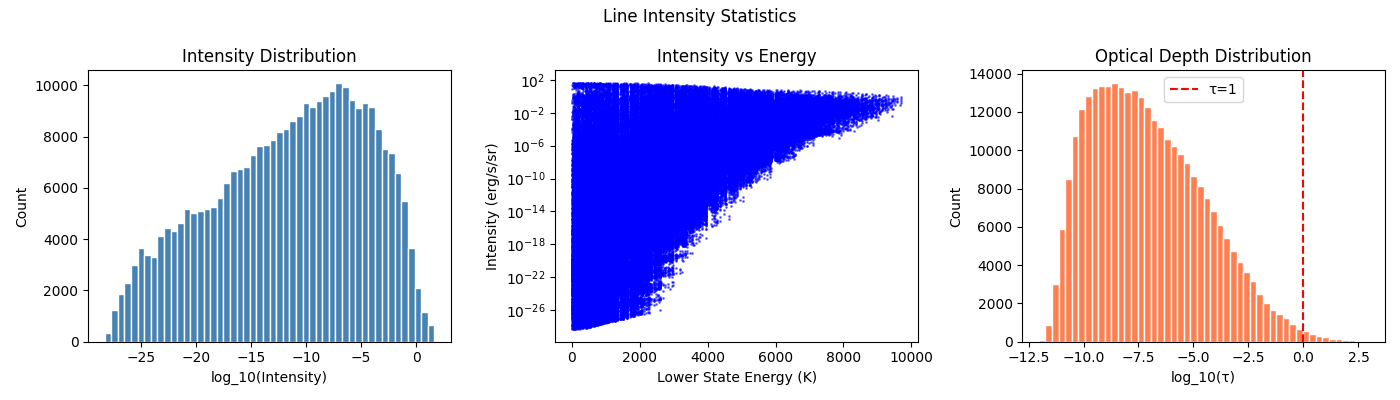

In [4]:
# --- Intensity Statistics with Interactive Temperature ---

fig2, axes = plt.subplots(1, 3, figsize=(14, 4))
fig2.suptitle('Line Intensity Statistics', fontsize=12)

# Initial calculation
intensity_calc2 = Intensity(line_list)
intensity_calc2.calc_intensity(t_kin=850, n_mol=1e18, dv=1.0)

# Get energy levels
e_low = line_list.get_lower_energies()

# Histogram of log intensities
ax_hist = axes[0]
log_intens = np.log10(intensity_calc2.intensity + 1e-30)
ax_hist.hist(log_intens, bins=50, color='steelblue', edgecolor='white')
ax_hist.set_xlabel('log_10(Intensity)')
ax_hist.set_ylabel('Count')
ax_hist.set_title('Intensity Distribution')

# Intensity vs lower energy level (Boltzmann diagram style)
ax_boltz = axes[1]
ax_boltz.scatter(e_low, intensity_calc2.intensity, s=1, alpha=0.5, c='blue')
ax_boltz.set_xlabel('Lower State Energy (K)')
ax_boltz.set_ylabel('Intensity (erg/s/sr)')
ax_boltz.set_yscale('log')
ax_boltz.set_title('Intensity vs Energy')

# Optical depth histogram
ax_tau = axes[2]
log_tau = np.log10(intensity_calc2.tau + 1e-30)
ax_tau.hist(log_tau, bins=50, color='coral', edgecolor='white')
ax_tau.set_xlabel('log_10(τ)')
ax_tau.set_ylabel('Count')
ax_tau.set_title('Optical Depth Distribution')
ax_tau.axvline(0, color='red', linestyle='--', label='τ=1')
ax_tau.legend()

plt.tight_layout()

# Temperature slider for stats
temp_slider2 = widgets.IntSlider(
    value=850, min=100, max=3000, step=100,
    description='Temperature (K):',
    continuous_update=True,
    style={'description_width': '120px'},
    layout=widgets.Layout(width='400px'),
)

stats_label = widgets.HTML(
    value="<b>Statistics will update with temperature</b>"
)

def update_stats(change):
    temp = float(temp_slider2.value)
    intensity_calc2.calc_intensity(t_kin=temp, n_mol=1e18, dv=1.0)
    
    log_intens = np.log10(intensity_calc2.intensity + 1e-30)
    log_tau = np.log10(intensity_calc2.tau + 1e-30)
    
    # Number of optically thick lines
    n_thick = np.sum(intensity_calc2.tau > 1)
    n_total = len(intensity_calc2.tau)
    
    stats_label.value = (
        f"<b>T = {temp} K</b><br>"
        f"Optically thick lines (τ > 1): {n_thick} / {n_total} ({100*n_thick/n_total:.1f}%)<br>"
        f"Max intensity: {intensity_calc2.intensity.max():.2e} erg/s/sr"
    )
    
    # Clear and redraw
    for ax in axes:
        ax.clear()
    
    axes[0].hist(log_intens, bins=50, color='steelblue', edgecolor='white')
    axes[0].set_xlabel('log_10(Intensity)')
    axes[0].set_ylabel('Count')
    axes[0].set_title('Intensity Distribution')
    
    axes[1].scatter(e_low, intensity_calc2.intensity, s=1, alpha=0.5, c='blue')
    axes[1].set_xlabel('Lower State Energy (K)')
    axes[1].set_ylabel('Intensity (erg/s/sr)')
    axes[1].set_yscale('log')
    axes[1].set_title('Intensity vs Energy')
    
    axes[2].hist(log_tau, bins=50, color='coral', edgecolor='white')
    axes[2].set_xlabel('log_10(τ)')
    axes[2].set_ylabel('Count')
    axes[2].set_title('Optical Depth Distribution')
    axes[2].axvline(0, color='red', linestyle='--', label='τ=1')
    axes[2].legend()
    
    fig2.canvas.draw_idle()

temp_slider2.observe(update_stats, names='value')

display(widgets.VBox([stats_label, temp_slider2]))
plt.show()